In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import featuretools as ft
import datetime as dt
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
from sklearn.ensemble import RandomForestClassifier

In [2]:
train_raw = pd.read_csv("data/train_revised.csv")
test_raw = pd.read_csv("data/test_questions.csv")

In [3]:
test_raw.head()

,ride_id,travel_date,travel_time,travel_from,travel_to,car_type,max_capacity
0,247,2018-05-07,07:06,Kisii,Nairobi,Bus,49
1,256,2018-05-06,11:08,Kisii,Nairobi,shuttle,11
2,275,2018-05-04,05:00,Kisii,Nairobi,shuttle,11
3,285,2018-05-04,09:10,Kisii,Nairobi,shuttle,11
4,286,2018-05-04,09:20,Kisii,Nairobi,shuttle,11


In [4]:
test_raw.shape

(1111, 7)

In [5]:
train_raw.head()

,ride_id,seat_number,payment_method,payment_receipt,travel_date,travel_time,travel_from,travel_to,car_type,max_capacity
0,1442,15A,Mpesa,UZUEHCBUSO,17-10-17,7:15,Migori,Nairobi,Bus,49
1,5437,14A,Mpesa,TIHLBUSGTE,19-11-17,7:12,Migori,Nairobi,Bus,49
2,5710,8B,Mpesa,EQX8Q5G19O,26-11-17,7:05,Keroka,Nairobi,Bus,49
3,5777,19A,Mpesa,SGP18CL0ME,27-11-17,7:10,Homa Bay,Nairobi,Bus,49
4,5778,11A,Mpesa,BM97HFRGL9,27-11-17,7:12,Migori,Nairobi,Bus,49


In [6]:
train_draft = train_raw.drop(columns=['seat_number', 'payment_method', 'payment_receipt'], axis=0)
train_draft.head()

,ride_id,travel_date,travel_time,travel_from,travel_to,car_type,max_capacity
0,1442,17-10-17,7:15,Migori,Nairobi,Bus,49
1,5437,19-11-17,7:12,Migori,Nairobi,Bus,49
2,5710,26-11-17,7:05,Keroka,Nairobi,Bus,49
3,5777,27-11-17,7:10,Homa Bay,Nairobi,Bus,49
4,5778,27-11-17,7:12,Migori,Nairobi,Bus,49


In [7]:
train_draft.shape

(51645, 7)

In [8]:
len(train_draft['ride_id'].unique())

6249

In [9]:
train_draft.dtypes

ride_id          int64
travel_date     object
travel_time     object
travel_from     object
travel_to       object
car_type        object
max_capacity     int64
dtype: object

In [10]:
tickets_df = train_draft.groupby(by=['ride_id'])['ride_id'].count().to_frame()
tickets_df = tickets_df.rename(columns = {'ride_id':'tickets'})
train_draft = pd.merge(train_draft,tickets_df,on='ride_id')

In [11]:
train_draft = train_draft.drop_duplicates()
train_draft.shape

(6249, 8)

In [12]:
train_draft.head()

,ride_id,travel_date,travel_time,travel_from,travel_to,car_type,max_capacity,tickets
0,1442,17-10-17,7:15,Migori,Nairobi,Bus,49,1
1,5437,19-11-17,7:12,Migori,Nairobi,Bus,49,1
2,5710,26-11-17,7:05,Keroka,Nairobi,Bus,49,1
3,5777,27-11-17,7:10,Homa Bay,Nairobi,Bus,49,5
8,5778,27-11-17,7:12,Migori,Nairobi,Bus,49,31


### Check for Null Values (None found)

<AxesSubplot:>

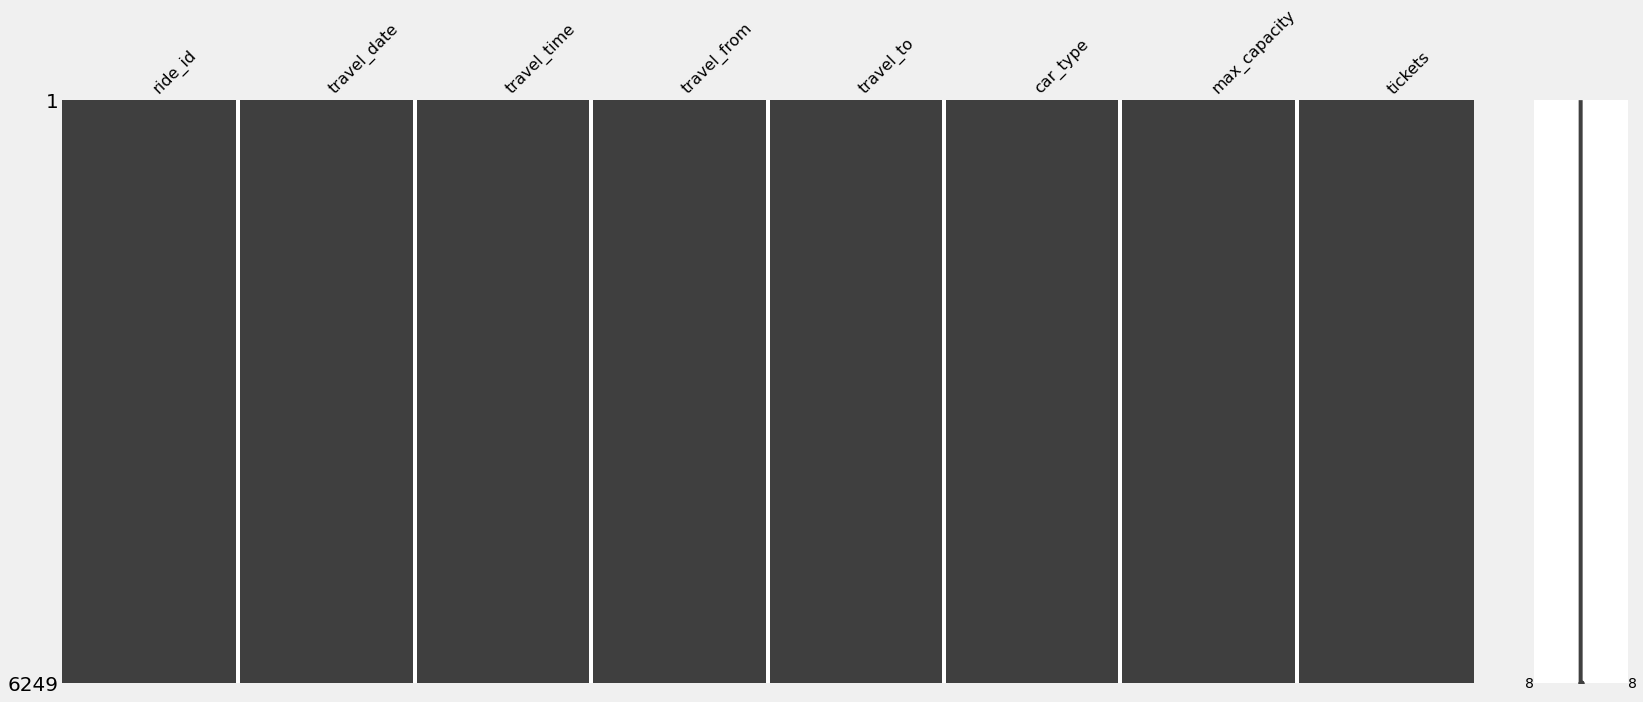

In [13]:
msno.matrix(train_draft)

### Replacing object dtypes with integer equivalents

In [14]:
train_nums = train_draft
train_nums.head()

,ride_id,travel_date,travel_time,travel_from,travel_to,car_type,max_capacity,tickets
0,1442,17-10-17,7:15,Migori,Nairobi,Bus,49,1
1,5437,19-11-17,7:12,Migori,Nairobi,Bus,49,1
2,5710,26-11-17,7:05,Keroka,Nairobi,Bus,49,1
3,5777,27-11-17,7:10,Homa Bay,Nairobi,Bus,49,5
8,5778,27-11-17,7:12,Migori,Nairobi,Bus,49,31


In [15]:
train_nums.dtypes

ride_id          int64
travel_date     object
travel_time     object
travel_from     object
travel_to       object
car_type        object
max_capacity     int64
tickets          int64
dtype: object

In [16]:
# Splitting the travel_date to year, month and date
train_nums['year'] = pd.DatetimeIndex(train_nums['travel_date']).year
train_nums['month'] = pd.DatetimeIndex(train_nums['travel_date']).month
train_nums['day'] = pd.DatetimeIndex(train_nums['travel_date']).day

# Converting travel_date to weekday (0 is monday and so on)
train_nums['travel_date'] = pd.to_datetime(train_nums["travel_date"], format = "%d-%m-%y")
train_nums["weekday"] = train_nums["travel_date"].dt.dayofweek 

# Converting travel_time to minutes
train_nums["travel_time_mins"] = train_nums["travel_time"].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))
train_nums['hour']= train_nums.travel_time.map(lambda x: pd.to_datetime(x).hour)

# Converting travel_from to corresponding integer
train_nums["travel_from"] = pd.Categorical(train_nums["travel_from"])
travel_from_categories = train_nums.travel_from.cat.categories
train_nums["travel_from_int"] = train_nums.travel_from.cat.codes
train_nums['travel_from_int'] = train_nums['travel_from_int'] + 1


# Converting car_type to corresponding integer (0 is bus 1 is shuttle)
train_nums["car_type"] = pd.Categorical(train_nums["car_type"])
travel_from_categories = train_nums.car_type.cat.categories
train_nums["car_type_int"] = train_nums.car_type.cat.codes


train_nums.head(15)

,ride_id,travel_date,travel_time,travel_from,travel_to,car_type,max_capacity,tickets,year,month,day,weekday,travel_time_mins,hour,travel_from_int,car_type_int
0,1442,2017-10-17,7:15,Migori,Nairobi,Bus,49,1,2017,10,17,1,435,7,10,0
1,5437,2017-11-19,7:12,Migori,Nairobi,Bus,49,1,2017,11,19,6,432,7,10,0
2,5710,2017-11-26,7:05,Keroka,Nairobi,Bus,49,1,2017,11,26,6,425,7,5,0
3,5777,2017-11-27,7:10,Homa Bay,Nairobi,Bus,49,5,2017,11,27,0,430,7,2,0
8,5778,2017-11-27,7:12,Migori,Nairobi,Bus,49,31,2017,11,27,0,432,7,10,0
39,5781,2017-11-27,7:09,Homa Bay,Nairobi,Bus,49,26,2017,11,27,0,429,7,2,0
65,5784,2018-04-20,5:10,Kisii,Nairobi,shuttle,11,1,2018,4,20,4,310,5,8,1
66,5789,2018-04-20,9:50,Kisii,Nairobi,shuttle,11,1,2018,4,20,4,590,9,8,1
67,5790,2018-04-20,7:06,Kisii,Nairobi,Bus,49,2,2018,4,20,4,426,7,8,0
69,5791,2018-04-20,6:00,Kisii,Nairobi,shuttle,11,1,2018,4,20,4,360,6,8,1


### Codes for travel from 

In [17]:
train_nums.groupby('travel_from')['travel_from_int'].unique()

travel_from
Awendo        [1]
Homa Bay      [2]
Kehancha      [3]
Kendu Bay     [4]
Keroka        [5]
Keumbu        [6]
Kijauri       [7]
Kisii         [8]
Mbita         [9]
Migori       [10]
Ndhiwa       [11]
Nyachenge    [12]
Oyugis       [13]
Rodi         [14]
Rongo        [15]
Sirare       [16]
Sori         [17]
Name: travel_from_int, dtype: object

In [18]:
train_edited = train_nums.drop(columns=['ride_id', 'travel_date', 'travel_time', 'travel_from',
                                      'travel_from', 'travel_to', 'car_type', ], axis=0)
train_edited.head()

,max_capacity,tickets,year,month,day,weekday,travel_time_mins,hour,travel_from_int,car_type_int
0,49,1,2017,10,17,1,435,7,10,0
1,49,1,2017,11,19,6,432,7,10,0
2,49,1,2017,11,26,6,425,7,5,0
3,49,5,2017,11,27,0,430,7,2,0
8,49,31,2017,11,27,0,432,7,10,0


In [19]:
features = np.array(['year', 'month', 'day', 'max_capacity', 'weekday', 'hour', 
                     'travel_time_mins', 'travel_from_int', 'car_type_int'])
clf = RandomForestClassifier()
clf.fit(train_edited[features], train_edited['tickets'])

RandomForestClassifier()

In [20]:
importances = clf.feature_importances_
sorted_idx = np.argsort(importances)

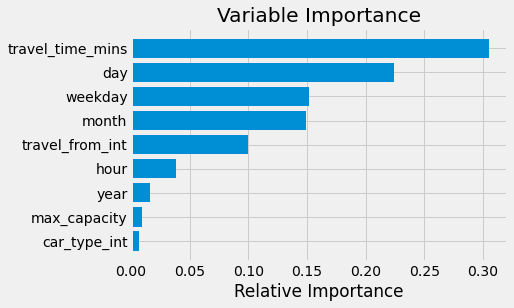

In [21]:
padding = np.arange(len(features)) + 0.5
plt.barh(padding, importances[sorted_idx], align='center')
plt.yticks(padding, features[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()